<a href="https://colab.research.google.com/github/ada-my619/Rock-Classification/blob/main/Rock_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rock Fabric Similarity & Classification (Performance Analysis Between Convolutional Deep Learning vs Classical KNN)

In [90]:
!pip install pycm livelossplot
%pylab inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary


import matplotlib.pyplot as plt
import numpy as np
import random

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.12/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cm', 'mean', 'std', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [91]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


In [92]:
set_seed(42)

True

## Import the data

In [93]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tanyadayanand/geological-image-similarity")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'geological-image-similarity' dataset.
Path to dataset files: /kaggle/input/geological-image-similarity


In [94]:
import os

os.listdir(path)

['geological_similarity']

In [95]:
count = 0
limit = 2
for folder in os.listdir(path):
    print(f"\n📁 {folder}")
    # print(os.listdir(os.path.join(path, folder)))
    for subfolder in os.listdir(os.path.join(path, folder)):
        print(f"  📁 {subfolder}")
        # print(os.listdir(os.path.join(path, folder, subfolder)))
        count = 0
        for file in os.listdir(os.path.join(path, folder, subfolder)):
            if count < limit:
              print(f"    📄 {file}")
            else:
              print("     ....")
              break
            count += 1



📁 geological_similarity
  📁 quartzite
    📄 N2LU6.jpg
    📄 BUPNC.jpg
     ....
  📁 gneiss
    📄 I3KSJ.jpg
    📄 SJEMY.jpg
     ....
  📁 rhyolite
    📄 FC4QB.jpg
    📄 1QLVM.jpg
     ....
  📁 schist
    📄 SN0YG.jpg
    📄 OUP9W.jpg
     ....
  📁 marble
    📄 F4N0B.jpg
    📄 G7IT2.jpg
     ....
  📁 andesite
    📄 10DY6.jpg
    📄 5U01A.jpg
     ....


See one image data

Dataset ImageFolder
    Number of datapoints: 29998
    Root location: /kaggle/input/geological-image-similarity/geological_similarity
    StandardTransform
Transform: Compose(
               ToTensor()
           ) 

{'andesite': 0, 'gneiss': 1, 'marble': 2, 'quartzite': 3, 'rhyolite': 4, 'schist': 5}
torch.Size([3, 28, 28])
0


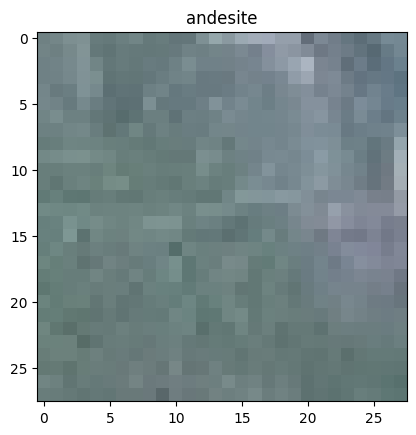

In [96]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

transform = transforms.Compose([
        transforms.ToTensor(),
    ])

rock_dataset = ImageFolder(root=os.path.join(path, "geological_similarity"), transform=transform)

print(rock_dataset, "\n")
print(rock_dataset.class_to_idx)

rock, target = rock_dataset[0]
print(rock.shape)
print(target)
plt.imshow(rock.permute(1, 2, 0))
plt.title(list(rock_dataset.class_to_idx)[target])
plt.show()

Split the dataset into train, validation, and test datasets

In [97]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

def split_dataset(dataset, train_size=0.7, val_size=0.2, test_size=0.1, seed=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6 # "train, val, and test sizes must sum to 1"

    targets = [label for _, label in dataset.samples]
    indices = np.arange(len(targets))

    train_idx, temp_idx = train_test_split(
        indices,
        test_size=(1.0 - train_size),
        stratify=targets,
        random_state=seed
    )

    # split temp into val and test
    temp_targets = [targets[i] for i in temp_idx]
    val_ratio = val_size / (val_size + test_size)

    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=(1.0 - val_ratio),
        stratify=temp_targets,
        random_state=seed
    )

    train_dataset = Subset(dataset, train_idx)
    val_dataset   = Subset(dataset, val_idx)
    test_dataset  = Subset(dataset, test_idx)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(rock_dataset)
print(len(train_dataset), len(val_dataset), len(test_dataset))

20998 5999 3001


Make sure there is no class imbalances

In [98]:
idx_to_class = {v: k for k, v in rock_dataset.class_to_idx.items()}
from collections import Counter

def print_class_proportion(dataset, name):
    labels = [dataset[i][1] for i in range(len(dataset))]
    counts = Counter(labels)
    total = len(labels)

    print(f"\n{name} (total = {total})")
    for label, count in sorted(counts.items()):
        class_name = idx_to_class[label]
        print(f"  {class_name:<10}: {count:>4} ({count/total:.2%})")
print_class_proportion(rock_dataset, "Full dataset")
print_class_proportion(train_dataset, "Train dataset")
print_class_proportion(val_dataset, "Validation dataset")
print_class_proportion(test_dataset, "Validation dataset")



Full dataset (total = 29998)
  andesite  : 5000 (16.67%)
  gneiss    : 5000 (16.67%)
  marble    : 4998 (16.66%)
  quartzite : 5000 (16.67%)
  rhyolite  : 5000 (16.67%)
  schist    : 5000 (16.67%)

Train dataset (total = 20998)
  andesite  : 3500 (16.67%)
  gneiss    : 3500 (16.67%)
  marble    : 3498 (16.66%)
  quartzite : 3500 (16.67%)
  rhyolite  : 3500 (16.67%)
  schist    : 3500 (16.67%)

Validation dataset (total = 5999)
  andesite  : 1000 (16.67%)
  gneiss    : 1000 (16.67%)
  marble    : 1000 (16.67%)
  quartzite :  999 (16.65%)
  rhyolite  : 1000 (16.67%)
  schist    : 1000 (16.67%)

Validation dataset (total = 3001)
  andesite  :  500 (16.66%)
  gneiss    :  500 (16.66%)
  marble    :  500 (16.66%)
  quartzite :  501 (16.69%)
  rhyolite  :  500 (16.66%)
  schist    :  500 (16.66%)


In [99]:
batch_size = 32

Calculate the mean & std for Normalization

In [100]:
from torch.utils.data import DataLoader
import torch

loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)
n_pixels = 0

for images, _ in loader:
    # images shape: (B, C, H, W)
    b, c, h, w = images.shape
    pixels = b * h * w
    n_pixels += pixels

    mean += images.sum(dim=[0, 2, 3])
    std  += (images ** 2).sum(dim=[0, 2, 3])

mean /= n_pixels
std = torch.sqrt(std / n_pixels - mean ** 2)

print(mean, std)

tensor([0.5081, 0.5197, 0.5193]) tensor([0.1860, 0.1984, 0.2188])


In [101]:
from numpy import random
import matplotlib.pyplot as plt

def get_classes(dataset):
    if hasattr(dataset, "classes"):
        return dataset.classes
    elif hasattr(dataset, "dataset") and hasattr(dataset.dataset, "classes"):
        return dataset.dataset.classes
    else:
        raise AttributeError("Dataset has no classes attribute")


def show_batch(dataset, nr=4, nc=4):
    classes = get_classes(dataset)

    fig, axarr = plt.subplots(nr, nc, figsize=(5, 5))
    for i in range(nr):
        for j in range(nc):
            idx = random.randint(0, len(dataset))
            sample, target = dataset[idx]

            # normalize for display if needed
            if sample.min() < 0.:
                sample = (sample - sample.min()) / (sample.max() - sample.min())

            # show image
            if sample.ndim == 3:
                axarr[i][j].imshow(sample.permute(1, 2, 0))
            else:
                axarr[i][j].imshow(sample)

            target_name = classes[target]
            axarr[i][j].set_title(f"{target_name} ({target})")
            axarr[i][j].axis("off")

    fig.tight_layout(pad=1.5)
    plt.show()


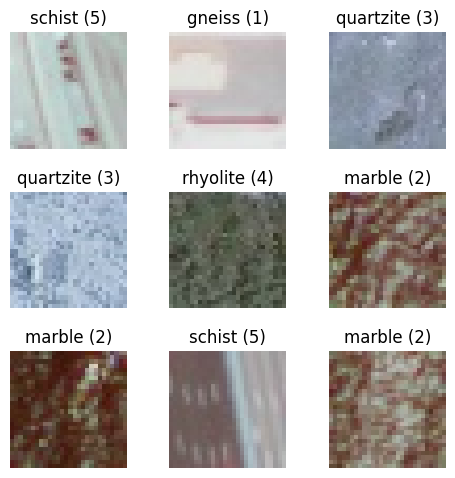

In [102]:
show_batch(train_dataset, 3, 3)

Transform the dataset

In [103]:
# Finally add normalisation to transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

rock_dataset = ImageFolder(root=os.path.join(path, "geological_similarity"), transform=transform)

train_dataset, val_dataset, test_dataset = split_dataset(rock_dataset)
print(len(train_dataset), len(val_dataset), len(test_dataset))

20998 5999 3001


Show the data

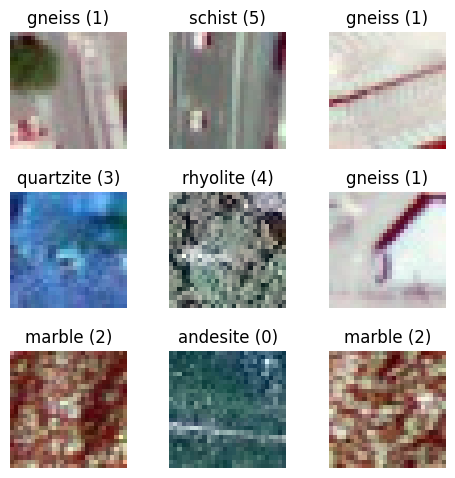

In [104]:
show_batch(train_dataset, 3, 3)

Make the dataloader

In [105]:
from torch.utils.data import Dataset

class IndexedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return x, y, idx

In [106]:
indexed_train_dataset = IndexedDataset(train_dataset)
indexed_val_dataset = IndexedDataset(val_dataset)
indexed_test_dataset = IndexedDataset(test_dataset)

In [107]:
train_loader = DataLoader(indexed_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(indexed_val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(indexed_test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Make the training, validation, and evaluation fucntion

In [108]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y, _ in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        # print(X.shape)
        a2 = model(X.view(-1, 3, 28, 28))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss.item()*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    with torch.no_grad():
      for X, y, _ in data_loader:
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 28, 28))
            loss = criterion(a2, y)
            validation_loss += loss.item()*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y, _ in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 3, 28, 28))
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

Now, after wrapping up our data, let proceed to make a Classifier, for this case since the image is quite small 28 x 28, a shallow & small CNN migh be enough

## Classification with CNN

Make the model with 3 convolutional layers and 2 linear layers. The first linear layer will be the embedding layer, later will be used for similarity task and also help us understand the space of the embeddings. The other one is a classifier layer that maps from the embedding to the logits/score

In [109]:
class SmallCNN(nn.Module):
    def __init__(self, in_channels=3, out=6, embedding_dim=256):
        super().__init__()

        # Conv layer
        self.features = nn.Sequential(
            # Block 1: 28x28 -> 28x28
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),

            # Block 2: 28x28 -> 14x14
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            # Block 3: 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )

        # Embedding Layer
        self.flatten = nn.Flatten()
        self.embedding = nn.Linear(128 * 7 * 7, embedding_dim)

        # Class layer
        self.class_layer = nn.Linear(embedding_dim, out)
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.embedding(x)
        x = self.class_layer(x)
        return x


Set some hyperparameters

In [110]:
lr = 1e-6
n_epochs = 20

In [111]:
small_cnn = SmallCNN().to(device)
summary(small_cnn, input_size=(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             896
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
            Conv2d-4           [-1, 64, 28, 28]          18,496
              ReLU-5           [-1, 64, 28, 28]               0
       BatchNorm2d-6           [-1, 64, 28, 28]             128
         MaxPool2d-7           [-1, 64, 14, 14]               0
            Conv2d-8          [-1, 128, 14, 14]          73,856
              ReLU-9          [-1, 128, 14, 14]               0
      BatchNorm2d-10          [-1, 128, 14, 14]             256
        MaxPool2d-11            [-1, 128, 7, 7]               0
          Flatten-12                 [-1, 6272]               0
           Linear-13                  [-1, 256]       1,605,888
           Linear-14                   

Train our model

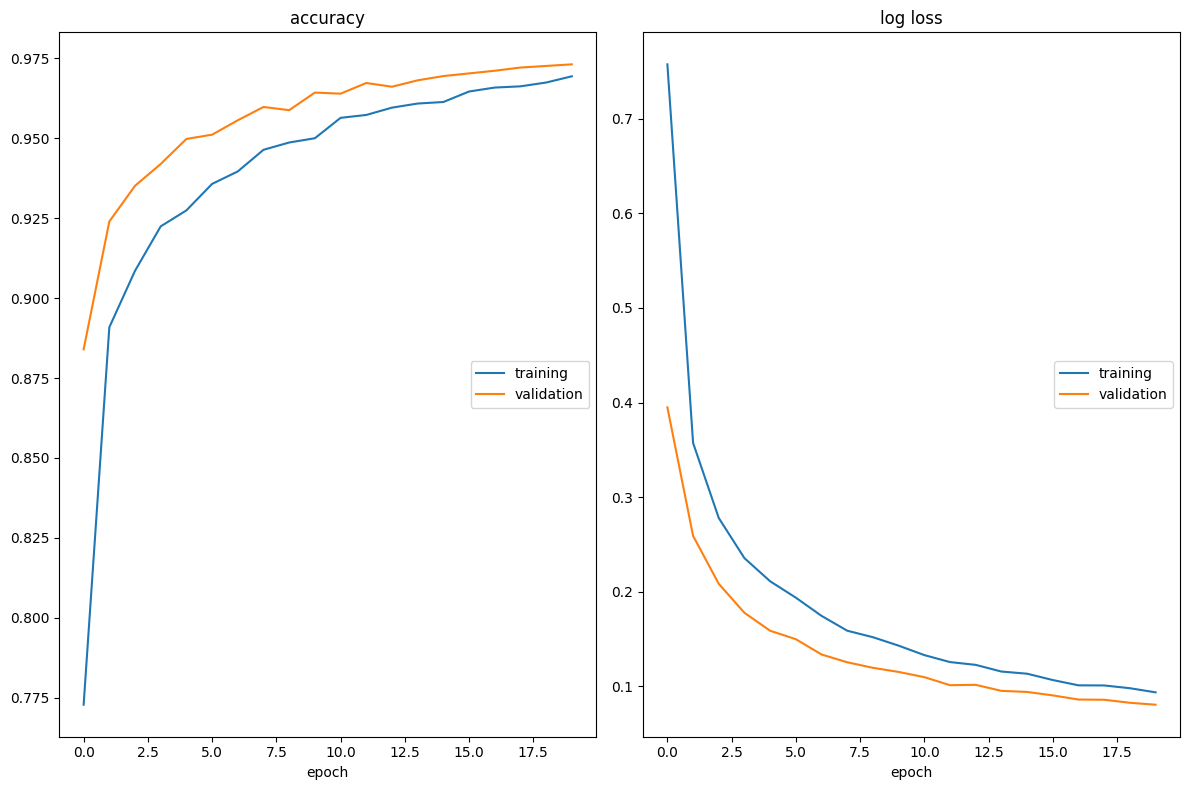

accuracy
	training         	 (min:    0.773, max:    0.969, cur:    0.969)
	validation       	 (min:    0.884, max:    0.973, cur:    0.973)
log loss
	training         	 (min:    0.094, max:    0.758, cur:    0.094)
	validation       	 (min:    0.081, max:    0.395, cur:    0.081)
Avg. Test Loss: 0.088  Avg. Test Accuracy: 0.973



In [112]:
optimizer = torch.optim.Adam(small_cnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(small_cnn, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss
    logs['' + 'accuracy'] = train_accuracy

    validation_loss, validation_accuracy = validate(small_cnn, criterion, val_loader)
    logs['val_' + 'log loss'] = validation_loss
    logs['val_' + 'accuracy'] = validation_accuracy

    liveloss.update(logs)
    liveloss.draw()

test_loss, test_accuracy = validate(small_cnn, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss, " Avg. Test Accuracy: %1.3f" % test_accuracy)
print("")

From the curve, we could see the training process is quite good, with around 97% of accuracy.

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       500
           1       0.96      0.98      0.97       500
           2       1.00      1.00      1.00       500
           3       0.97      0.98      0.97       501
           4       0.97      0.98      0.98       500
           5       0.98      0.94      0.96       500

    accuracy                           0.97      3001
   macro avg       0.97      0.97      0.97      3001
weighted avg       0.97      0.97      0.97      3001



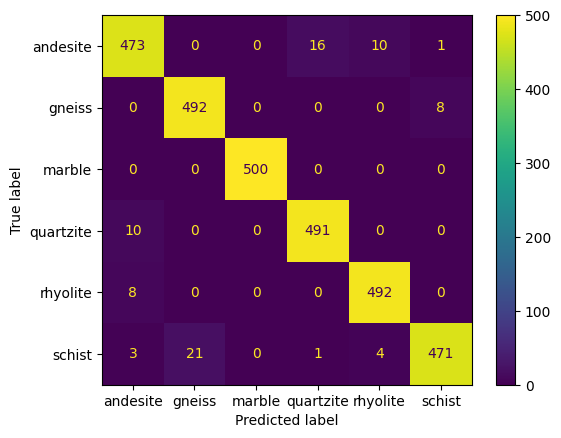

In [113]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# create the confusion matrix for prediction
y_pred, y_true = evaluate(small_cnn, test_loader)

cm = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print(classification_report(y_true, y_pred))
# make the label 0, 1, 2,... to folder name
cm.ax_.set_xticklabels(list(rock_dataset.class_to_idx))
cm.ax_.set_yticklabels(list(rock_dataset.class_to_idx))
plt.show()
print(cm)

The confusion matrix also shows a good result, with some error classifying rocks that kind of similar in texture (schist vs gneiss) and (andesite vs rhyolite & andesite vs quartzite)

[  43   51   83  180  193  214  257  275  338  351  387  409  416  445
  494  496  554  649  693  721  827  889  901  910  931 1036 1041 1049
 1050 1061 1190 1262 1271 1340 1366 1496 1504 1589 1593 1612 1614 1618
 1622 1649 1688 1690 1712 1730 1734 1742 1775 1777 1860 1870 1884 2031
 2106 2113 2221 2257 2265 2309 2367 2378 2380 2394 2463 2503 2530 2564
 2571 2625 2639 2785 2799 2852 2906 2930 2947 2956 2958 2970]
82


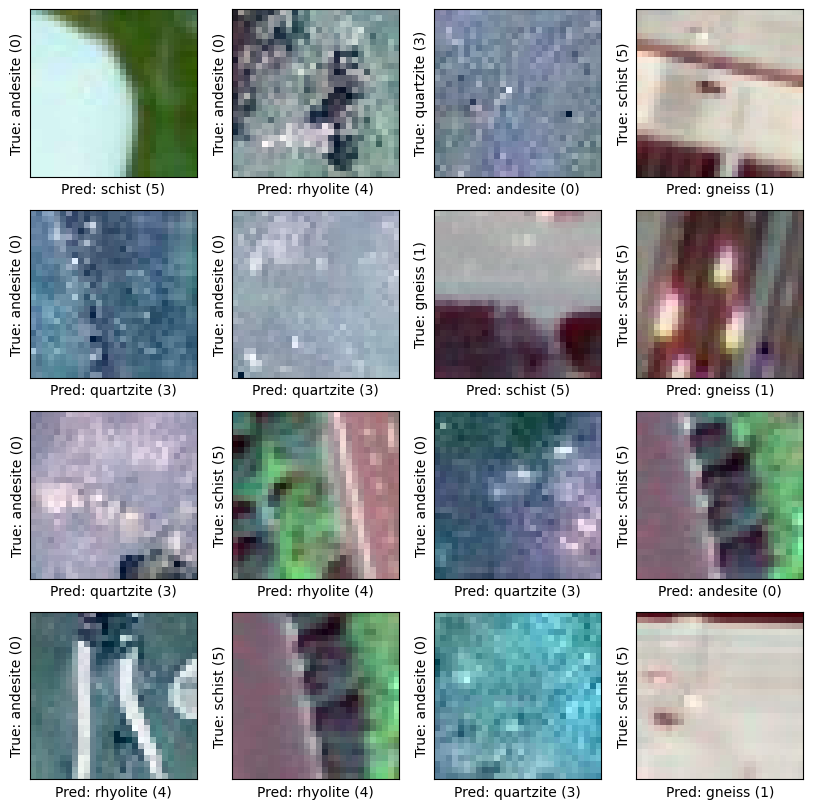

In [114]:
# plot side by side the image it predicts wrong and the true image

wrong_idx = np.where(y_pred != y_true)[0]
print(wrong_idx)
print(len(wrong_idx))
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    idx = wrong_idx[i]

    img = test_dataset[idx][0]
    if img.min() < 0.:
          img = (img - img.min()) / (img.max() - img.min())
    plt.imshow(img.permute(1, 2, 0))
    plt.xlabel(f"Pred: {idx_to_class[y_pred[idx]]} ({y_pred[idx]})")
    plt.ylabel(f"True: {idx_to_class[y_true[idx]]} ({y_true[idx]})")
plt.show()

To help interpret our classifier model, we could plot the saliency map, where we can see which pixel the model deems most important to separate the data into classes and then draw the decision boundary.

In [135]:
import torch
import matplotlib.pyplot as plt

def saliency(model, x, class_idx=None):
    model.eval()
    x_in = x.unsqueeze(0).to(device)
    x_in.requires_grad_(True)

    logits = model(x_in)
    if class_idx is None:
        class_idx = logits.argmax(dim=1).item()

    score = logits[0, class_idx]
    grad = torch.autograd.grad(score, x_in)[0][0]          # (C,H,W)
    sal = grad.abs().max(dim=0)[0]                         # (H,W)
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)
    return sal.detach().cpu()

def get_test_samples(model, dataset, num_classes, n_per_class, mode, is_pred=True):
    assert mode in {"correct", "wrong"}

    picked = {c: [] for c in range(num_classes)}  # store tuples (idx, true, pred)
    N = len(dataset)

    model.eval()
    with torch.no_grad():
        for i in range(N):
            x, y, idx = dataset[i]

            pred = model(x.unsqueeze(0).to(device)).argmax(dim=1).item()

            ok = (pred == y) if mode == "correct" else (pred != y)
            if ok and len(picked[y]) < n_per_class:
              if is_pred:
                  picked[y].append((idx, y, pred))
              else:
                  picked[y].append((x, y, idx, pred))
    return picked

def plot_saliency_by_outcome(model, dataset, n_per_class=3, mode="correct"):
    base = dataset if hasattr(dataset, "classes") else dataset.dataset.dataset
    classes = base.classes
    num_classes = len(classes)
    picked = get_test_samples(model, dataset, num_classes, n_per_class, mode)

    fig, axes = plt.subplots(num_classes, n_per_class * 2,
                             figsize=(3 * n_per_class * 2, 2 * num_classes))
    fig.suptitle(f"Actual vs Overlayed Saliency Map ({mode.title()} Prediction) \n", fontweight="bold", fontsize=16)
    if num_classes == 1:
        axes = axes[None, :]

    for c in range(num_classes):
        for k in range(n_per_class):
            ax_img = axes[c, 2*k]
            ax_sal = axes[c, 2*k + 1]

            if k >= len(picked[c]):
                ax_img.axis("off"); ax_sal.axis("off")
                continue

            idx, y, pred = picked[c][k]
            x, _, _ = dataset[idx]

            img = x.detach().cpu()
            if img.min() < 0:
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)

            # saliency for the predicted class (what drove the model's decision)
            s = saliency(model, x, class_idx=pred)

            ax_img.imshow(img.permute(1,2,0))
            if mode == "correct":
                ax_img.set_title(f"{classes[y].title()}", fontsize=10, verticalalignment="center")
            else:
                ax_img.set_title(f"True: {classes[y]} \n Pred: {classes[pred]}", fontsize=10, verticalalignment="center")
            ax_img.axis("off")

            #---- UNCOMMENT THIS BIT IF YOU WANT TO SEE SALIENCY WITHOUT OVERLAY
            # ax_sal.imshow(s, cmap="magma", interpolation="bilinear")
            # ax_sal.set_title("Saliency (Overlay)", fontsize=10)

            #---- COMMENT THIS BIT IF YOU WANT TO SEE SALIENCY WITHOUT OVERLAY
            ax_sal.imshow(img.permute(1, 2, 0))
            ax_sal.imshow(
                s,
                cmap="inferno",        # best perceptual colormap
                alpha=0.6,           # transparency
                interpolation="bilinear"
            )
            ax_sal.set_title("Saliency (Overlay)", fontsize=10, verticalalignment="center")
            # ------

            ax_sal.axis("off")

    plt.tight_layout()
    plt.show()


In [136]:
indexed_test_dataset

In [137]:
test_dataset

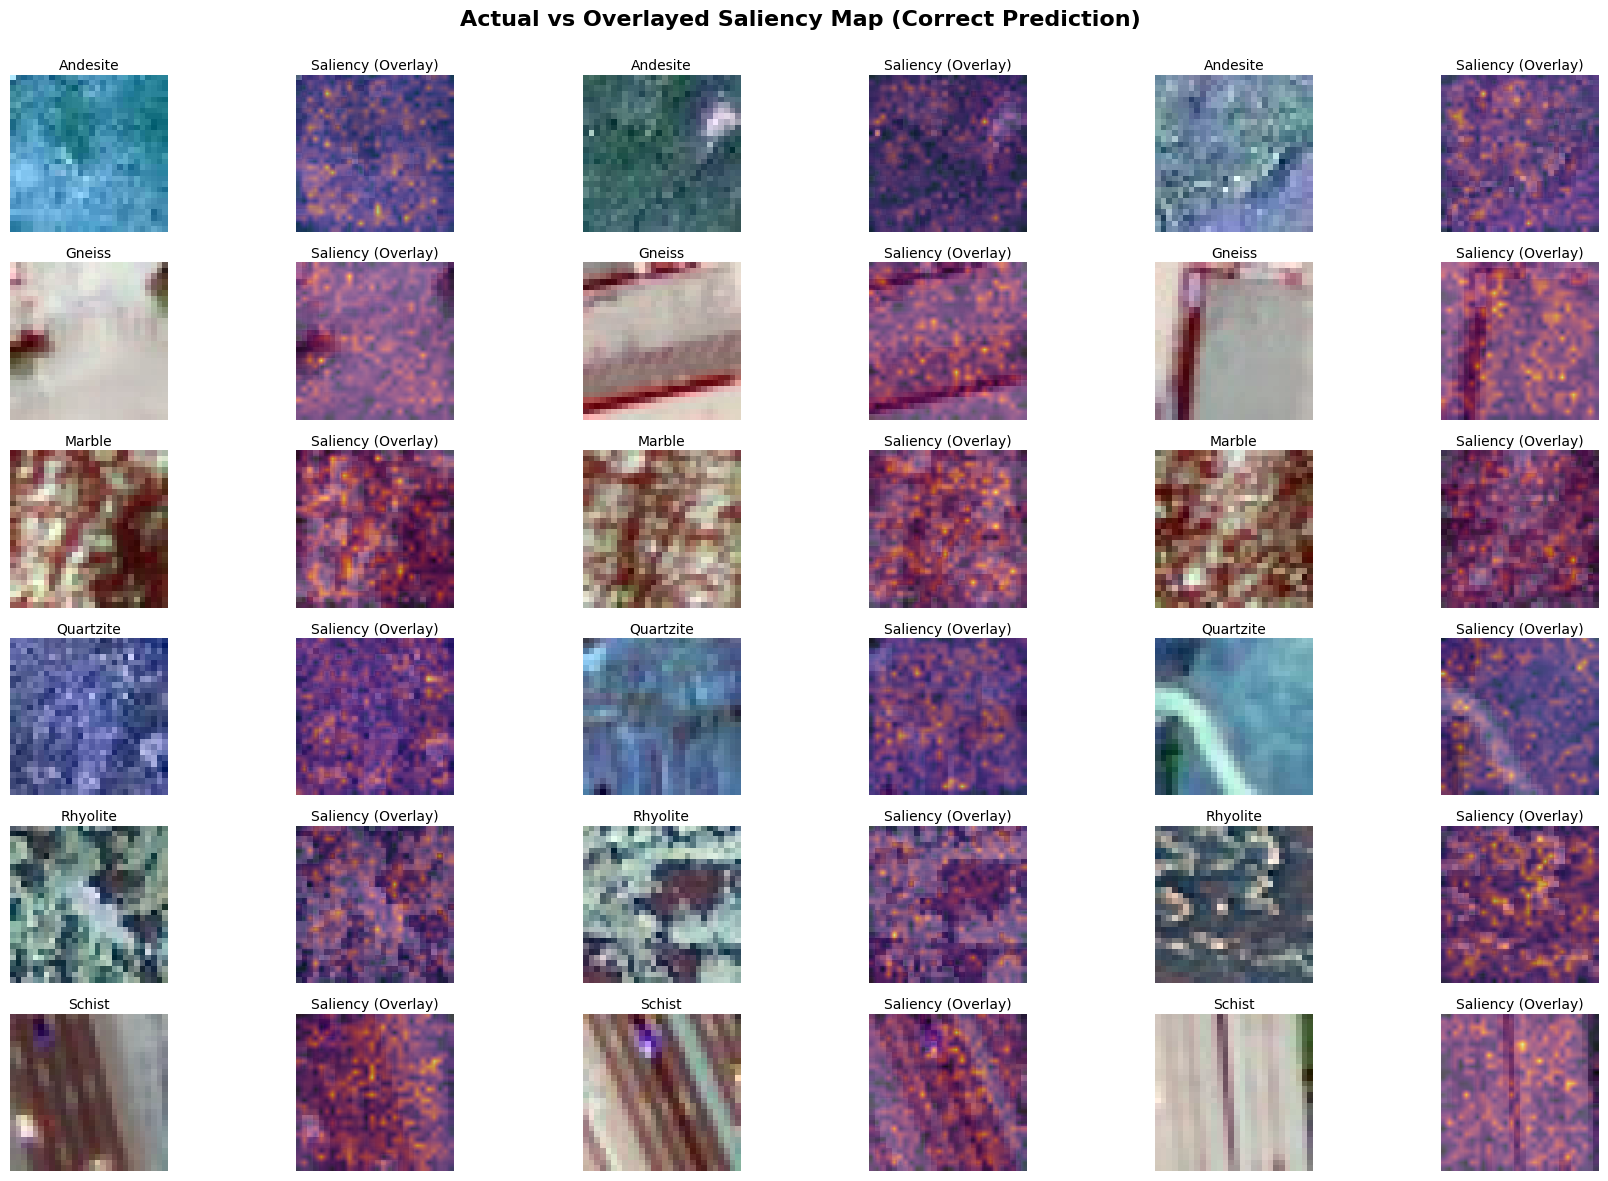

In [138]:
plot_saliency_by_outcome(
    small_cnn,
    indexed_test_dataset,
    n_per_class=3,
    mode="correct",
)

When the model predicts correctly, we could see that in some image the pixel with high value actually denotes the boundary and shape of the minerals that differentiate the rocks. (e.g. Marble, this model does a lot better in the Marble when it predict all cases as right)

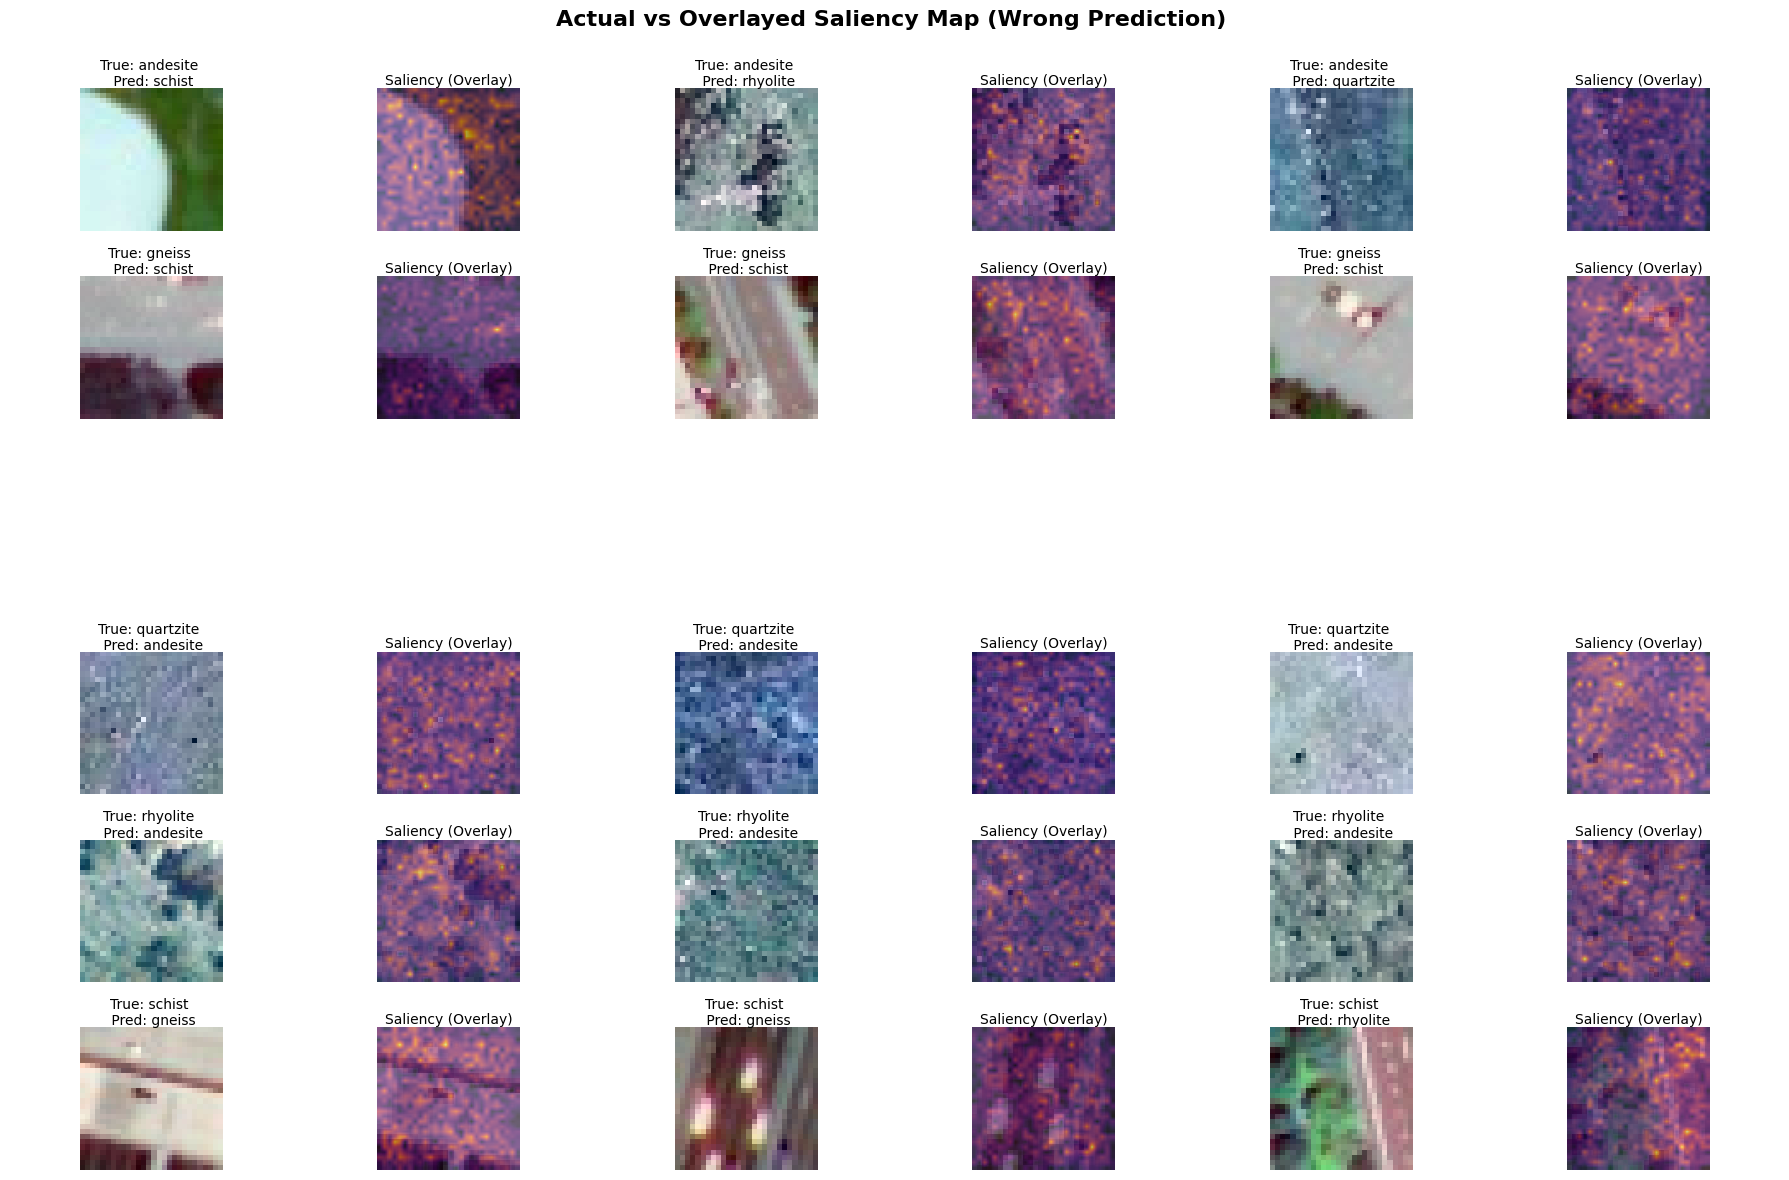

In [140]:
plot_saliency_by_outcome(small_cnn, indexed_test_dataset, n_per_class=3, mode="wrong")

When the model predicts wrong, it seems like it fails to highlight the important pixels that differentiate the rock types and instead highlighting another pixel that is less important. Hence saliency looks noisy and the model fails to classify the data to the right class.

## Rock Fabric Similarity

Here, we will try to find 5 top most similar sample given an input image. In order to do this, we will use our existing model and instead of the logit/classifier layer, we want the value of the embedding layer.

In [208]:
def build_embedding_space(model, dataloader, device):
    """
    Returns:
        embeddings: (N, D) tensor
        labels:     (N,) tensor
    """
    model.eval()

    all_embeddings = []
    all_labels = []
    all_indices = []

    with torch.no_grad():
        for x, y, idx in dataloader:
            x = x.to(device)

            h = model.features(x)
            h = h.view(h.size(0), -1)      # or model.flatten(h)
            emb = model.embedding(h)       # <-- embedding layer output
            emb = F.normalize(emb, dim=1)

            all_embeddings.append(emb.cpu())
            all_labels.append(y.cpu())
            all_indices.append(idx.cpu())

    embeddings = torch.cat(all_embeddings, dim=0)
    labels = torch.cat(all_labels, dim=0)
    indices = torch.cat(all_indices, dim=0)

    return embeddings, labels, indices

In [209]:
embeddings, labels, embeddings_indices = build_embedding_space(small_cnn, train_loader, device)

In [210]:
embeddings.shape, labels.shape, embeddings_indices.shape

(torch.Size([20998, 256]), torch.Size([20998]), torch.Size([20998]))

Now we got our embedding space and its labels. To ease our visualization, lets use Principal Component Analysis (PCA) to reduce the dimension from 256 to 50 and then plot the first 2 principal components in 2D.

In [211]:
from sklearn.decomposition import PCA
n_components = 50
pca = PCA(n_components=n_components)
embedding_space_projected = pca.fit_transform(embeddings)
embedding_space_projected.shape

(20998, 50)

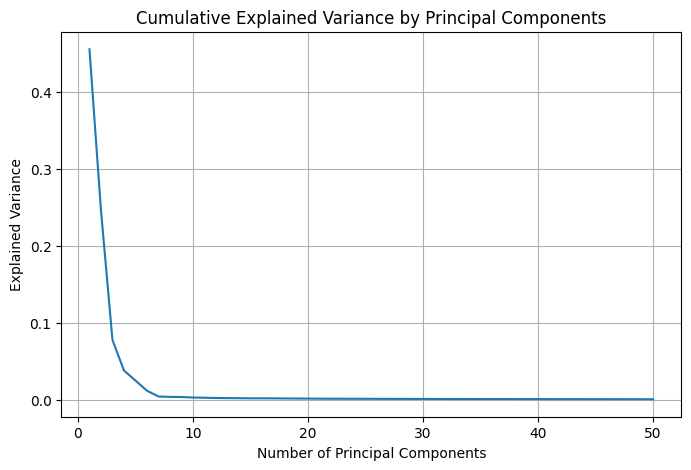

[0.45579956 0.24646665 0.07782536 0.03810307 0.02503629 0.01183954
 0.00437618 0.00382081 0.00367121 0.00297196 0.0027092  0.00237952
 0.00221216 0.00213097 0.00197219 0.00195006 0.00192721 0.00178861
 0.00170792 0.00160318 0.00148941 0.00142705 0.00140287 0.00136568
 0.00132168 0.00129223 0.00125703 0.001234   0.00120769 0.00115063
 0.00111825 0.00109645 0.00107902 0.00104786 0.00102387 0.00101059
 0.00098598 0.00096255 0.0009436  0.00093429 0.00091391 0.00089935
 0.00089663 0.00087863 0.00086373 0.00082976 0.00082299 0.0008063
 0.00080372 0.00079009]
[0.45579956 0.70226621 0.78009157 0.81819464 0.84323093 0.85507047
 0.85944665 0.86326747 0.86693867 0.86991064 0.87261983 0.87499935
 0.87721151 0.87934248 0.88131467 0.88326473 0.88519195 0.88698056
 0.88868847 0.89029165 0.89178106 0.89320811 0.89461098 0.89597667
 0.89729835 0.89859058 0.89984761 0.90108161 0.9022893  0.90343994
 0.90455819 0.90565464 0.90673366 0.90778153 0.90880539 0.90981598
 0.91080197 0.91176452 0.91270811 0.913

In [212]:
explained_variances = pca.explained_variance_ratio_
cumulative_explained_variances = explained_variances.cumsum()
plt.figure(figsize=(8,5))
plt.plot(range(1, n_components + 1), explained_variances)
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.grid()
plt.show()

print(explained_variances)
print(cumulative_explained_variances)

In [213]:
minimal_pc_count = (cumulative_explained_variances >= 0.90).argmax() + 1
print(f"Number of principal components to retain at least 90% variance: {minimal_pc_count}")

Number of principal components to retain at least 90% variance: 28


In [214]:
rock_dataset.classes

['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

Next, visualize our embedding space

In [215]:
def plot_embedding_2d(
    embedding_2d,
    labels,
    class_names,
    title="PCA: PC1 vs PC2",
    xlabel="PC 1",
    ylabel="PC 2",
    figsize=(8, 5),
    point_size=12,
    legend_loc="lower right"
):

    plt.figure(figsize=figsize)

    for cls_id, cls_name in enumerate(class_names):
        mask = (labels == cls_id)
        if mask.sum() == 0:
            continue
        plt.scatter(
            embedding_2d[mask, 0],
            embedding_2d[mask, 1],
            s=point_size,
            label=cls_name
        )

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(title="Class", loc=legend_loc)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

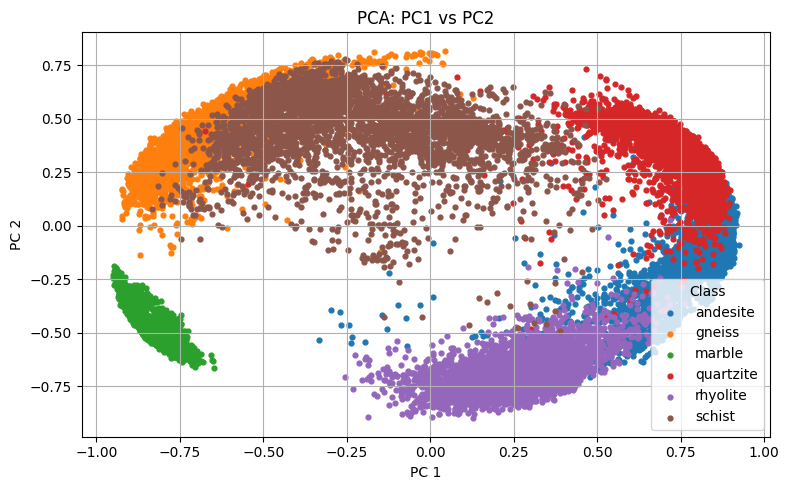

In [216]:
plot_embedding_2d(
    embedding_space_projected,
    labels,
    rock_dataset.classes
)

We could see the embedding space managed to be linearly separable by the PCA. We could see the classes of rocks clearly distinguishable one from the other.

From the classification task before, we could see that the model manage to predict Marble classes correct 100% and based on the plotted projected embedding space, we also able to see that the embedding space is clearly separated from the other classes. Moreover, we were able to observe that there are overlapping sector between andesite vs quartzite and andesite vs rhyolite class, matching our observed classification problem where it's hard to distinguish between them.

Moving on to the Similarity Task, in order to find the most similar image to a given input, we will use Nearest Neighbour algorithm that calculate distances between the embeddings and return the top first k value.

In [217]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(
    metric="cosine",
    algorithm="auto"
)

nn.fit(embeddings)     # embeddings shape: (N, D)

NearestNeighbors(metric='cosine')

Get the correct test samples, here we get 3 samples for each class

In [218]:
sample_num = 3
top_neighbor_num = 5

In [219]:
test_sample_correct = get_test_samples(small_cnn, indexed_test_dataset, len(rock_dataset.classes), sample_num, "correct", is_pred=False)

In [220]:
def embed_test_samples(model, samples_dict, device):
    model.eval()
    embedded = {}

    with torch.no_grad():
        for cls_id, items in samples_dict.items():
            emb_list = []
            for x, y, idx, pred in items:
                x = x.unsqueeze(0).to(device)

                h = model.features(x)
                h = h.view(h.size(0), -1)
                emb = model.embedding(h)
                emb = F.normalize(emb, dim=1)

                emb_list.append((emb.cpu(), pred, y, idx))

            embedded[cls_id] = emb_list

    return embedded

Change the test samples into embedding

In [221]:
test_embeddings_correct = embed_test_samples(small_cnn, test_sample_correct, device)

Make a query function to calculate the nearest k neighbours given an image query

In [222]:
import copy

def query_nn_for_test_embeddings(
    nn,
    test_embeddings,
    train_labels,
    class_names,
    topk=5
):
    output = {}
    for cls_id, emb_list in test_embeddings.items():
        print(f"\nQuery class: {class_names[cls_id]}")
        output[cls_id] = {}
        for i, (emb, pred, y, idx) in enumerate(emb_list): #<- Check if idx == indices got from nn.kneighbors, which should be included in n[el]?
            ent = {
                "pred": pred,
                "label": y,
                "neighbours": None
            }
            distances, indices = nn.kneighbors(emb, n_neighbors=topk)
            neighbor_labels = train_labels[indices[0]]
            n = {}
            for el in range(len(neighbor_labels)):
                n[el] = {
                    "distance": distances[0][el],
                    "label": neighbor_labels[el],
                    "idx": indices[0][el],
                }
                ent["neighbours"] = n
            output[cls_id][idx] = ent
            print(f"  Sample {i+1} (Pred: {class_names[pred]}): Nearest labels ->",
                  [class_names[l] for l in neighbor_labels])
    return output


In [223]:
test_correct_plot = query_nn_for_test_embeddings(
    nn,
    test_embeddings_correct,
    labels,
    rock_dataset.classes,
    topk=top_neighbor_num
)


Query class: andesite
  Sample 1 (Pred: andesite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'andesite']
  Sample 2 (Pred: andesite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'andesite']
  Sample 3 (Pred: andesite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'andesite']

Query class: gneiss
  Sample 1 (Pred: gneiss): Nearest labels -> ['gneiss', 'schist', 'gneiss', 'gneiss', 'gneiss']
  Sample 2 (Pred: gneiss): Nearest labels -> ['gneiss', 'gneiss', 'gneiss', 'gneiss', 'gneiss']
  Sample 3 (Pred: gneiss): Nearest labels -> ['gneiss', 'gneiss', 'gneiss', 'gneiss', 'gneiss']

Query class: marble
  Sample 1 (Pred: marble): Nearest labels -> ['marble', 'marble', 'marble', 'marble', 'marble']
  Sample 2 (Pred: marble): Nearest labels -> ['marble', 'marble', 'marble', 'marble', 'marble']
  Sample 3 (Pred: marble): Nearest labels -> ['marble', 'marble', 'marble', 'marble', 'marble']

Query class: quartzite
  Sample 1 

Here we can see the query image with certain label matches the label of the nearest neighbours

Lets get the test saple that predicts wrong

In [224]:
test_sample_wrong = get_test_samples(small_cnn, indexed_test_dataset, len(rock_dataset.classes), sample_num, "wrong", is_pred=False)

In [225]:
test_embeddings_wrong = embed_test_samples(small_cnn, test_sample_wrong, device)

In [226]:
test_wrong_plot = query_nn_for_test_embeddings(
    nn,
    test_embeddings_wrong,
    labels,
    rock_dataset.classes,
    topk=top_neighbor_num
)


Query class: andesite
  Sample 1 (Pred: schist): Nearest labels -> ['andesite', 'quartzite', 'andesite', 'quartzite', 'andesite']
  Sample 2 (Pred: rhyolite): Nearest labels -> ['rhyolite', 'rhyolite', 'rhyolite', 'rhyolite', 'rhyolite']
  Sample 3 (Pred: quartzite): Nearest labels -> ['quartzite', 'quartzite', 'andesite', 'andesite', 'quartzite']

Query class: gneiss
  Sample 1 (Pred: schist): Nearest labels -> ['gneiss', 'gneiss', 'gneiss', 'gneiss', 'gneiss']
  Sample 2 (Pred: schist): Nearest labels -> ['schist', 'gneiss', 'schist', 'gneiss', 'schist']
  Sample 3 (Pred: schist): Nearest labels -> ['gneiss', 'schist', 'gneiss', 'gneiss', 'gneiss']

Query class: marble

Query class: quartzite
  Sample 1 (Pred: andesite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'andesite']
  Sample 2 (Pred: andesite): Nearest labels -> ['andesite', 'andesite', 'andesite', 'andesite', 'andesite']
  Sample 3 (Pred: andesite): Nearest labels -> ['andesite', 'andesite', 'andesi

Here we can see the nearest neighbour label of a given input sample can be differ from the true sample label and varies. But why they are considered similar even if it is a different rock classes? We'll see in a moment

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_similarity_with_headers(
    test_correct_plot,
    test_dataset,
    db_dataset,
    class_names,
    top_neighbor_num=5,
    sample_num=3,
    figsize_scale=1.8,
    header_color="#EAEAF2",
    between_class_space=0.35,
    between_sample_space=0.12,
    title="Correct"
):
    """
    Layout:
      [Class header row spanning all columns]
      sample 1: [Query | NN1 | ... | NNk]
      sample 2: [Query | NN1 | ... | NNk]
      sample 3: [Query | NN1 | ... | NNk]
      (repeat per class)

    Notes on indices:
      - sample_id must index into test_dataset.dataset if you use test_dataset.dataset[sample_id]
        If sample_id indexes the subset directly, replace test_dataset.dataset[sample_id] with test_dataset[sample_id]
      - neighbor idx must index into db_dataset (train/val embedding DB), not test_dataset
    """
    n_classes = len(class_names)
    cols = 1 + top_neighbor_num  # Query + neighbors

    # total rows = headers + samples
    total_rows = n_classes * (1 + sample_num)

    fig = plt.figure(
        figsize=(figsize_scale * cols, figsize_scale * n_classes * (sample_num + 0.8))
    )

    fig.suptitle(
        f"Similarity Plot ({title} Prediction)",
        fontsize=16,
        fontweight="bold",
        y=0.995
    )

    # Use GridSpec with custom height ratios (headers shorter)
    height_ratios = []
    for _ in range(n_classes):
        height_ratios.append(0.35)        # header row
        height_ratios.extend([1.0] * sample_num)  # sample rows

    gs = fig.add_gridspec(
        nrows=total_rows,
        ncols=cols,
        height_ratios=height_ratios,
        wspace=0.2,   # inside-row spacing
        hspace=between_sample_space
    )

    def _prep_img(x):
        # x: (C,H,W) tensor or numpy
        img = x.detach().cpu() if hasattr(x, "detach") else x
        img = img.float()
        mn, mx = img.min(), img.max()
        img = (img - mn) / (mx - mn + 1e-8)
        img = img.permute(1, 2, 0).numpy() if hasattr(img, "permute") else img
        return img

    row_ptr = 0 # row pinter

    for cls_id in range(n_classes):
        # header row spanning all columns
        axh = fig.add_subplot(gs[row_ptr, :])
        axh.axis("off")

        # header background bar
        axh.add_patch(
            Rectangle(
                (0, 0), 1, 1,
                transform=axh.transAxes,
                facecolor=header_color,
                edgecolor="none",
                zorder=0
            )
        )
        axh.text(
            0.01, 0.5,
            f"True Class {class_names[cls_id]}:",
            va="center", ha="left",
            fontsize=12, fontweight="bold"
        )
        row_ptr += 1

        # Items for this class (may be missing if your dict isn't complete)
        cls_items = test_correct_plot.get(cls_id, {})

        # We want up to sample_num rows for this class
        sample_ids = list(cls_items.keys())[:sample_num]

        # --- sample rows ---
        for s_i in range(sample_num):
            if s_i >= len(sample_ids):
                # empty row
                for c in range(cols):
                    ax = fig.add_subplot(gs[row_ptr, c])
                    ax.axis("off")
                row_ptr += 1
                continue

            sample_id = sample_ids[s_i]
            neigh_dict = cls_items[sample_id]["neighbours"]
            sample_ent = cls_items[sample_id]
            #print(sample_ent["x"].shape)
            # Query image (IMPORTANT: adjust indexing if needed)
            # xq, yq = test_dataset.dataset[sample_id]  # <-- if sample_id is base-dataset index
            xq, yq = test_dataset[sample_id]        # <-- use this if sample_id is subset index

            axq = fig.add_subplot(gs[row_ptr, 0])
            axq.imshow(_prep_img(xq))
            axq.axis("off")
            axq.set_title(f"Sample {s_i+1} \n (pred: {class_names[sample_ent["pred"]]})", fontsize=10, pad=2)

            # Neighbors
            neigh_keys = list(neigh_dict.keys())[:top_neighbor_num]
            for j in range(top_neighbor_num):
                axn = fig.add_subplot(gs[row_ptr, 1 + j])
                axn.axis("off")

                if j >= len(neigh_keys):
                    continue

                nk = neigh_keys[j]
                db_idx = neigh_dict[nk]["idx"]
                real_neigh_idx = embeddings_indices[db_idx]

                xn, yn, idk = db_dataset[real_neigh_idx]
                # print(idk, real_neigh_idx)
                axn.imshow(_prep_img(xn))
                axn.set_title(f"NN{j+1} dist: {neigh_dict[nk]["distance"]:.4f} \n (label: {class_names[neigh_dict[nk]["label"]]})", fontsize=10, pad=2)

            # Light separator line between samples (optional)
            # Draw a faint horizontal line by using the leftmost axis position
            if s_i < sample_num - 1:
                # add a little extra space between sample rows inside a class
                pass

            row_ptr += 1

    fig.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.02, hspace=between_class_space)
    plt.show()


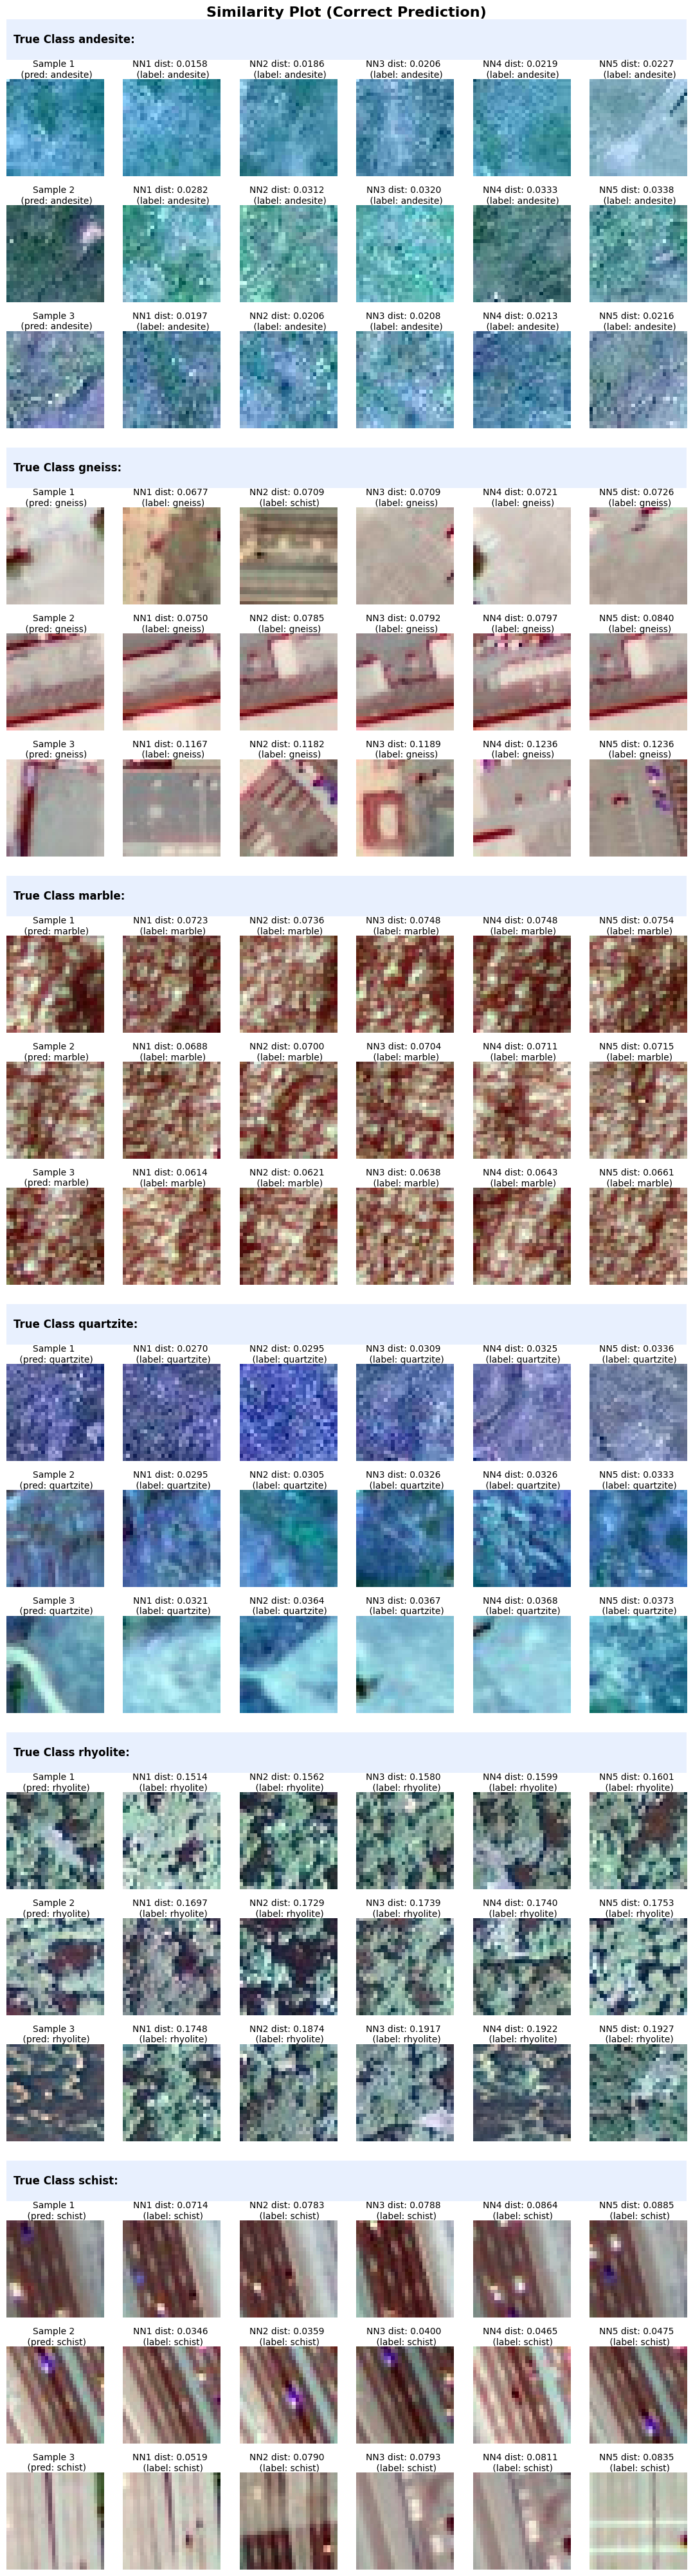

In [228]:
plot_similarity_with_headers(
    test_correct_plot=test_correct_plot,
    test_dataset=test_dataset,
    db_dataset=indexed_train_dataset,            # Dataset where the neighbour data comes from
    class_names=rock_dataset.classes,
    top_neighbor_num=5,
    sample_num=3,
    header_color="#E8F0FE",
    between_class_space=0.35,
    between_sample_space=0.10,
    title="Correct"
)

We could see when the model manages to classify the rock into it's respected class, the similarity between it and it's neighbours is very apparent, whether it is the texture, mineral form, or the spread of the minerals in the image itself.

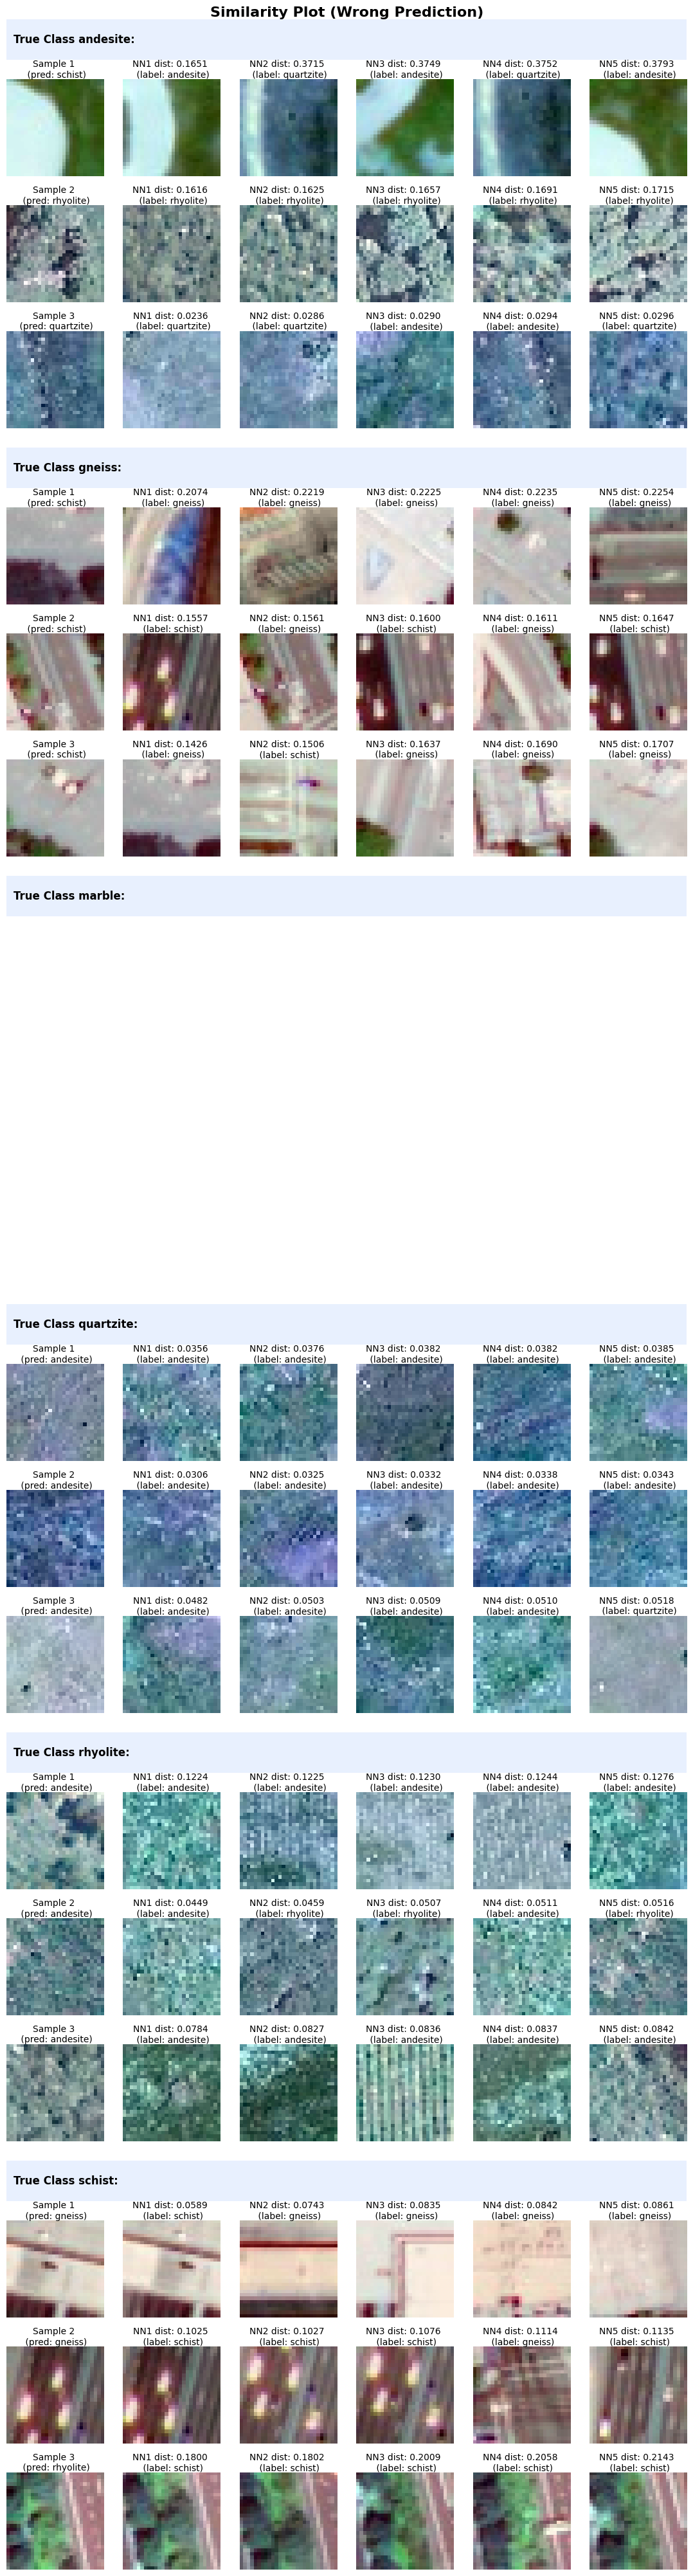

In [229]:
plot_similarity_with_headers(
    test_correct_plot=test_wrong_plot,
    test_dataset=test_dataset,
    db_dataset=indexed_train_dataset,            # Dataset where the neighbour data comes from
    class_names=rock_dataset.classes,
    top_neighbor_num=5,
    sample_num=3,
    header_color="#E8F0FE",
    between_class_space=0.35,
    between_sample_space=0.10,
    title="Wrong"
)

In the other hand, when the model fails to classify the rock to its respective class, it nearest neighbours is actually very close in terms of image to the input. it's just the model fails to extract those features and classify it into its respective class in the last layer. It could be due to compressing 256 dimension embeddings into 6 class is too much for the model that it makes the model fails to draw a clear decision boundary.

Looking at the similarity between its neighbour, we could predict that using classical machine learning (like KNN) will produce a better result with the embeddings as a training data.

## Classification with KNN

In [230]:
# use KNN Classifier to classify
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(embedding_space_projected, labels)

KNeighborsClassifier()

In [231]:
test_embeddings_space, test_embeddings_labels, test_embeddings_indices = build_embedding_space(small_cnn, test_loader, device)

In [237]:
test_embeddings_labels.numpy()

array([2, 1, 5, ..., 5, 4, 4])

In [232]:
# project test data to 50 pca
from sklearn.decomposition import PCA
test_embeddings_space_projected = pca.transform(test_embeddings_space)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       500
           1       0.98      0.99      0.99       500
           2       1.00      1.00      1.00       500
           3       0.98      0.98      0.98       501
           4       0.98      0.98      0.98       500
           5       0.99      0.97      0.98       500

    accuracy                           0.98      3001
   macro avg       0.98      0.98      0.98      3001
weighted avg       0.98      0.98      0.98      3001



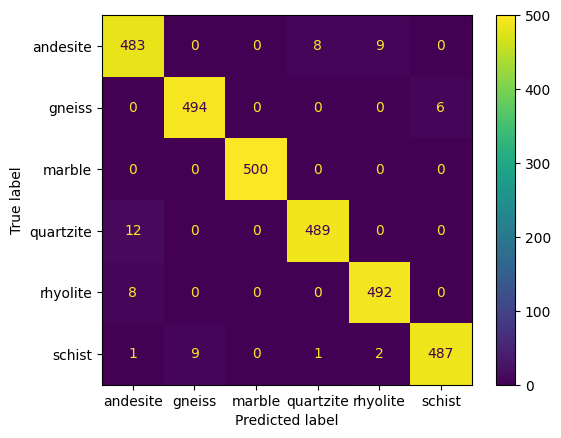

In [240]:
# let's evaluate the prediction
from sklearn.metrics import classification_report
y_pred_knn = knn_classifier.predict(test_embeddings_space_projected)
knn_conf_matrix = ConfusionMatrixDisplay.from_predictions(test_embeddings_labels.numpy(), y_pred_knn)
print(classification_report(test_embeddings_labels.numpy(), y_pred_knn))
# make the label 0, 1, 2,... to folder name
knn_conf_matrix.ax_.set_xticklabels(list(rock_dataset.class_to_idx))
knn_conf_matrix.ax_.set_yticklabels(list(rock_dataset.class_to_idx))
plt.show()

As we infer above, looking at the similarity with it's neighbour, the performance of KNN here surpass a convolutional deep learning model (98% vs 97% respectively).  